In [27]:
import os
import torch
import numpy as np
import random

def seed_everything(seed):
    """
    Set random seed for reproducibility
    """
    # 1. Python & Numpy
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
    # 2. PyTorch (CPU & GPU)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    print(f"🔒 Locked Random Seed: {seed}")


In [28]:



def seed_everything_random():
    """
    Tạo random seed, set seed đó, và return seed để bạn biết
    """
    # Tạo random seed
    random_seed = random.randint(0, 999999)
    
    # Set seed
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    np.random.seed(random_seed)
    random.seed(random_seed)
    
    # Để reproducible
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    return random_seed


In [29]:
#import
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from preprocess import get_sampler

In [30]:
#load data
df_men =pd.read_csv(r"C:\Users\Lenovo\Documents\Neu 2025-2026\Lab\Hillstrom-Men.csv")
df_men = df_men.drop(columns="Unnamed: 0")
print ("---------------------------")
print ("null count:")
print (df_men.isnull().sum())
print ("---------------------------")
print(df_men.dtypes)
print ("---------------------------")
print ("labels:")
print(df_men.columns.tolist())
print ("---------------------------")
print("data shape:")
print(df_men.shape)


---------------------------
null count:
recency            0
history_segment    0
history            0
mens               0
womens             0
zip_code           0
newbie             0
channel            0
visit              0
conversion         0
spend              0
treatment          0
dtype: int64
---------------------------
recency              int64
history_segment     object
history            float64
mens                 int64
womens               int64
zip_code            object
newbie               int64
channel             object
visit                int64
conversion           int64
spend              float64
treatment            int64
dtype: object
---------------------------
labels:
['recency', 'history_segment', 'history', 'mens', 'womens', 'zip_code', 'newbie', 'channel', 'visit', 'conversion', 'spend', 'treatment']
---------------------------
data shape:
(42613, 12)


In [31]:
#Hillstrom-men
#split num and cate
cate_cols = ['zip_code', 'channel']
df_men["history_segment"] =df_men["history_segment"].map({
    "1) $0 - $100": '1', 
    "2) $100 - $200": "2", 
    "3) $200 - $350": "3",
    "4) $350 - $500": "4",
    "5) $500 - $750": "5",
    "6) $750 - $1,000": "6",
    "7) $1,000 +": "7"                         
})
num_cols = ['recency', 'history_segment']
#split x y t
y_men = df_men["spend"]
t_men = df_men["treatment"]
x_men = df_men.drop(columns=["spend", "treatment", "visit", "conversion", 'history'])

x_men_encode = pd.get_dummies(x_men, columns=cate_cols, drop_first=True)
x_men_encode = x_men_encode.astype(float)
#train test split
x_men_train, x_men_test_val, t_men_train, t_men_test_val, y_men_train, y_men_test_val = train_test_split(x_men_encode,t_men.values, y_men.values, test_size=0.4, random_state=42, stratify=t_men)
x_men_val, x_men_test, t_men_val, t_men_test, y_men_val, y_men_test = train_test_split(x_men_test_val, t_men_test_val, y_men_test_val, test_size= 0.75, random_state=42, stratify=t_men_test_val)

#scale
# scaler = StandardScaler()
# x_men_train[num_cols]= scaler.fit_transform(x_men_train[num_cols])
# # x_men_val[num_cols] = scaler.transform(x_men_val[num_cols])
# x_men_test[num_cols] = scaler.transform(x_men_test[num_cols])

x_men_train = x_men_train.values.astype(float)
x_men_val = x_men_val.values.astype(float)
x_men_test = x_men_test.values.astype(float)
print (x_men_train[:10])


[[ 8.  4.  1.  0.  0.  0.  0.  1.  0.]
 [ 8.  1.  0.  1.  0.  0.  0.  1.  0.]
 [11.  2.  0.  1.  1.  0.  1.  1.  0.]
 [ 4.  1.  1.  0.  0.  0.  1.  0.  1.]
 [ 2.  1.  0.  1.  0.  0.  0.  1.  0.]
 [10.  3.  0.  1.  0.  0.  0.  0.  1.]
 [ 7.  2.  0.  1.  0.  1.  0.  1.  0.]
 [11.  1.  0.  1.  1.  0.  1.  1.  0.]
 [10.  2.  1.  0.  1.  0.  0.  1.  0.]
 [ 9.  1.  1.  0.  1.  1.  0.  1.  0.]]


In [32]:
#Transform to tensor
def to_tensor(df):
    return torch.tensor(df, dtype=torch.float32)

x_men_train_t = to_tensor(x_men_train)
x_men_val_t = to_tensor(x_men_val)
x_men_test_t = to_tensor(x_men_test)

y_men_train_t = to_tensor(y_men_train).unsqueeze(1)
y_men_val_t = to_tensor(y_men_val).unsqueeze(1)
y_men_test_t = to_tensor(y_men_test).unsqueeze(1)

t_men_train_t = to_tensor(t_men_train.astype(float)).unsqueeze(1)
t_men_val_t = to_tensor(t_men_val.astype(float)).unsqueeze(1)
t_men_test_t = to_tensor(t_men_test.astype(float)).unsqueeze(1)


#dual stream 
idx_t = (t_men_train==1)
idx_c = (t_men_train==0)

x_treat = x_men_train_t[idx_t]
t_treat = t_men_train_t[idx_t]
y_treat = y_men_train_t[idx_t]

x_ctrl = x_men_train_t[idx_c]
t_ctrl = t_men_train_t[idx_c]
y_ctrl = y_men_train_t[idx_c]

# sampler_treat = get_sampler(y_treat, target_positive_ratio=0.2)
# sampler_control = get_sampler(y_ctrl, target_positive_ratio=0.2)
#Data loader
train_t_dataset = TensorDataset(x_men_train_t[idx_t], t_men_train_t[idx_t], y_men_train_t[idx_t])
train_c_dataset = TensorDataset(x_men_train_t[idx_c], t_men_train_t[idx_c], y_men_train_t[idx_c])
val_dataset = TensorDataset(x_men_val_t, t_men_val_t, y_men_val_t)
test_dataset = TensorDataset(x_men_test_t, t_men_test_t, y_men_test_t)

batch_size = 6400
# train_t_loader = DataLoader(train_t_dataset, batch_size= batch_size//2, sampler = sampler_treat, shuffle=False)
# train_c_loader = DataLoader(train_c_dataset, batch_size= batch_size//2, sampler= sampler_control, shuffle= False)
train_t_loader = DataLoader(train_t_dataset, batch_size= batch_size//2, shuffle=True)
train_c_loader = DataLoader(train_c_dataset, batch_size= batch_size//2, shuffle= True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print ("-------------------------------------------------------------")
print ("✅Completed tranform to tensor✅")
print (f"Shape of train: x={x_men_train_t.shape}; y ={y_men_train_t.shape}; t={t_men_train_t.shape}")
print (f"Shape of val: x={x_men_val_t.shape}; y={y_men_val_t.shape}; t={t_men_val_t.shape}")
print (f"Shape of test: x={x_men_test_t.shape}; y={y_men_test_t.shape}; t={t_men_test_t.shape}")



-------------------------------------------------------------
✅Completed tranform to tensor✅
Shape of train: x=torch.Size([25567, 9]); y =torch.Size([25567, 1]); t=torch.Size([25567, 1])
Shape of val: x=torch.Size([4261, 9]); y=torch.Size([4261, 1]); t=torch.Size([4261, 1])
Shape of test: x=torch.Size([12785, 9]); y=torch.Size([12785, 1]); t=torch.Size([12785, 1])


Evaluation metrics

In [33]:
from metrics import auuc, auqc, lift, krcc

Build Model

In [34]:
from dragonnet import Dragonnet

In [35]:
print("📊 Data Distribution Check:")
print(f"Y train: mean={y_men_train.mean():.4f}, std={y_men_train.std():.4f}")
print(f"Y train zeros: {(y_men_train == 0).sum()} / {len(y_men_train)} ({(y_men_train == 0).sum()/len(y_men_train)*100:.1f}%)")
print(f"\nTreatment balance:")
print(f"  Train: {(t_men_train == 1).sum()} treated, {(t_men_train == 0).sum()} control")
print(f"  Test:  {(t_men_test == 1).sum()} treated, {(t_men_test == 0).sum()} control")

📊 Data Distribution Check:
Y train: mean=1.0188, std=14.8554
Y train zeros: 25342 / 25567 (99.1%)

Treatment balance:
  Train: 12784 treated, 12783 control
  Test:  6392 treated, 6393 control


In [36]:
# seed = seed_everything_random()
# print(f"Using seed: {seed}")

# print(f"Experiment completed with seed: {seed}")

In [ ]:
seed = 1
seed_everything(seed)

🔒 Locked Random Seed: 10


In [ ]:
dragonnet = Dragonnet(input_dim=x_men_train_t.shape[1], epochs=50, alpha = 0, beta =0, learning_rate=1e-3)
dragonnet.fit(train_t_loader, train_c_loader, val_loader)

print ("Complete training")

🔃🔃🔃Begin training Dragonnet🔃🔃🔃
Epoch 1 | Train Loss: 431.6871 | Val Loss: 823.8549
Epoch 2 | Train Loss: 431.3871 | Val Loss: 823.6496
Epoch 3 | Train Loss: 431.0650 | Val Loss: 823.4598
Epoch 4 | Train Loss: 430.8885 | Val Loss: 823.2824
Epoch 5 | Train Loss: 430.9354 | Val Loss: 823.1232
Epoch 6 | Train Loss: 430.6803 | Val Loss: 822.9775
Epoch 7 | Train Loss: 430.6842 | Val Loss: 822.8375
Epoch 8 | Train Loss: 430.5125 | Val Loss: 822.7028
Epoch 9 | Train Loss: 430.6187 | Val Loss: 822.5687
Epoch 10 | Train Loss: 430.2774 | Val Loss: 822.4227
Epoch 11 | Train Loss: 430.1378 | Val Loss: 822.2704
Epoch 12 | Train Loss: 430.2370 | Val Loss: 822.1116
Epoch 13 | Train Loss: 429.7007 | Val Loss: 821.9204
Epoch 14 | Train Loss: 429.6668 | Val Loss: 821.7312
Epoch 15 | Train Loss: 429.6151 | Val Loss: 821.5570
Epoch 16 | Train Loss: 429.3083 | Val Loss: 821.3795
Epoch 17 | Train Loss: 429.3636 | Val Loss: 821.2188
Epoch 18 | Train Loss: 429.1387 | Val Loss: 821.0850
Epoch 19 | Train Loss: 4

Evaluating baseline🔃🔃🔃


c:\Users\Lenovo\Documents\Neu 2025-2026\Lab\Baseline\dragonnet.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32, device=self.device)


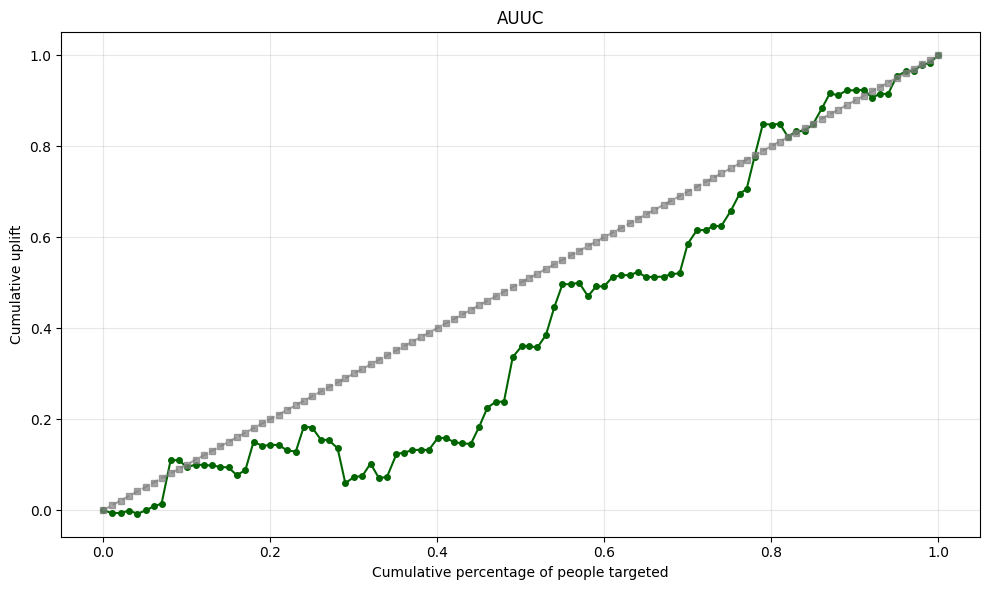

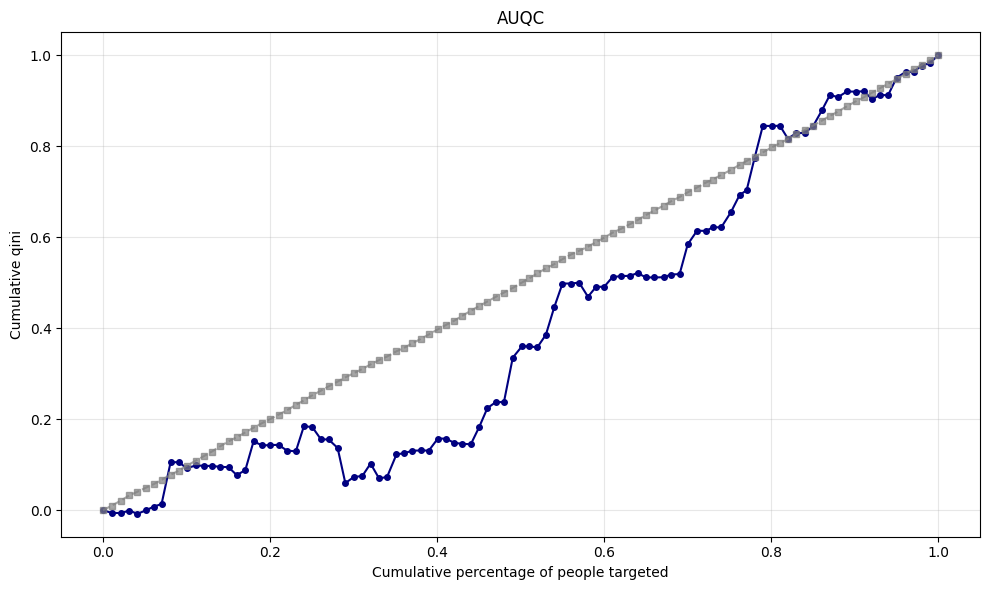

----------------------------------------
AUUC:  0.4050967260691961
AUQC:  0.40390850413136936
Lift:  0.19364094734191895
KRCC:  -0.12204190694630185
seed: 10


In [39]:
print ("Evaluating baseline🔃🔃🔃")
# Ensure the input tensor is on the same device as the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x_men_test_t_on_device = x_men_test_t.to(device)

y0_pred, y1_pred, _,_ = dragonnet.predict(x_men_test_t_on_device)

# Move predicted tensors back to CPU before converting to numpy arrays
uplift_pred = (y1_pred - y0_pred).cpu().numpy().flatten()

y_true = y_men_test_t.cpu().numpy().flatten() # Ensure true labels are also on CPU if they were ever moved
t_true = t_men_test_t.cpu().numpy().flatten() # Ensure true treatments are also on CPU if they were ever moved

auuc_score = auuc(y_true, t_true, uplift_pred, bins=100, plot=True)
auqc_score = auqc(y_true, t_true, uplift_pred, bins=100, plot=True)
lift_score = lift(y_true, t_true, uplift_pred, h=0.3)
krcc_score = krcc(y_true, t_true, uplift_pred, bins= 100)

print ("-"*40)
print ("AUUC: ", auuc_score)
print ("AUQC: ", auqc_score)
print ("Lift: ", lift_score)
print ("KRCC: ", krcc_score)
print (f"seed: {seed}")